# Run a set of Estimators on a simulated dataset

In [1]:
%matplotlib inline

In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from nimare.transforms import t_to_z

import pymare

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


200612-11:28:29,866 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.0)


INFO:nipype.utils:Running nipype version 1.4.2 (latest: 1.5.0)


In [3]:
def var_to_ci(y, v, n):
    """Convert sampling variance to 95% CI"""
    term = 1.96 * np.sqrt(v) / np.sqrt(n)
    return y - term, y + term

## Simulate some data

In [4]:
n_studies = 40
between_study_var = 200  # population variance
between_study_sd = np.sqrt(between_study_var)
true_effect = 20
sample_sizes = np.round(np.random.normal(loc=50, scale=20, size=n_studies)).astype(int)
within_study_vars = np.random.normal(loc=400, scale=100, size=n_studies)
study_means = np.random.normal(loc=true_effect, scale=between_study_sd, size=n_studies)

sample_sizes[sample_sizes <= 1] = 2
within_study_vars = np.abs(within_study_vars)

In [5]:
# Convert data types and match PyMARE nomenclature
y = study_means
X = np.ones((n_studies))
v = within_study_vars
n = sample_sizes
sd = np.sqrt(v * n)
z = y / sd
p = stats.norm.sf(abs(z)) * 2

## Plot variable distributions

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


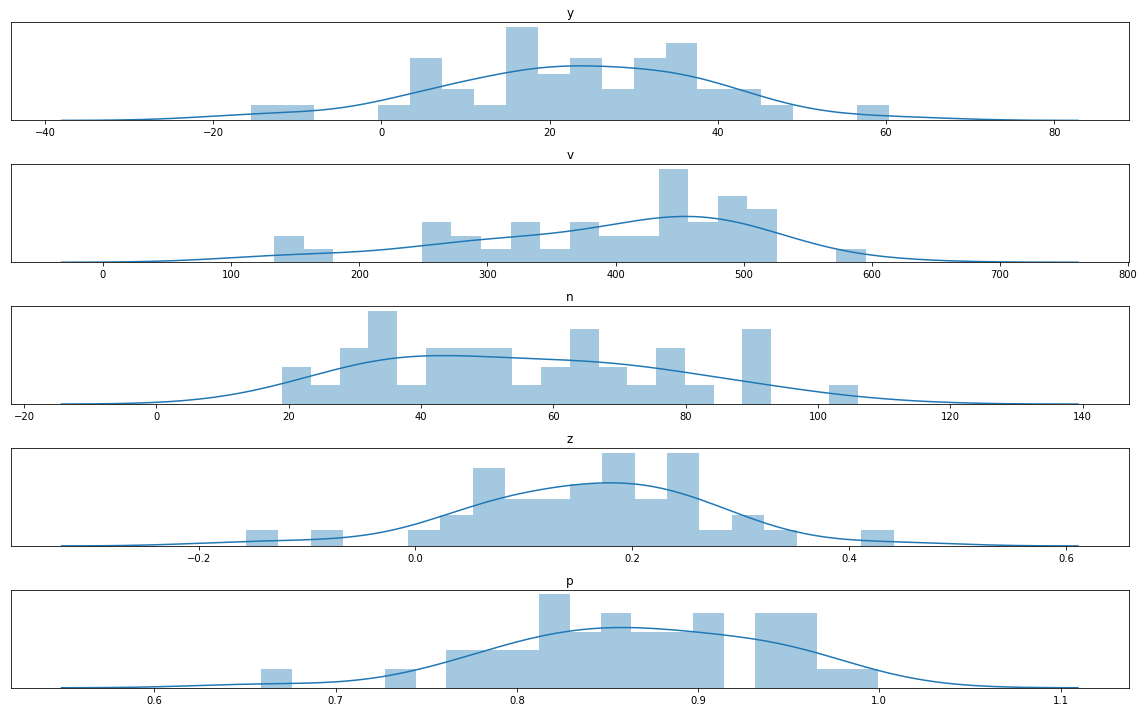

In [6]:
fig, axes = plt.subplots(nrows=5, figsize=(16, 10))
sns.distplot(y, ax=axes[0], bins=20)
axes[0].set_title('y')
sns.distplot(v, ax=axes[1], bins=20)
axes[1].set_title('v')
sns.distplot(n, ax=axes[2], bins=20)
axes[2].set_title('n')
sns.distplot(z, ax=axes[3], bins=20)
axes[3].set_title('z')
sns.distplot(p, ax=axes[4], bins=20)
axes[4].set_title('p')
for i in range(5):
    axes[i].set_yticks([])
fig.tight_layout()
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


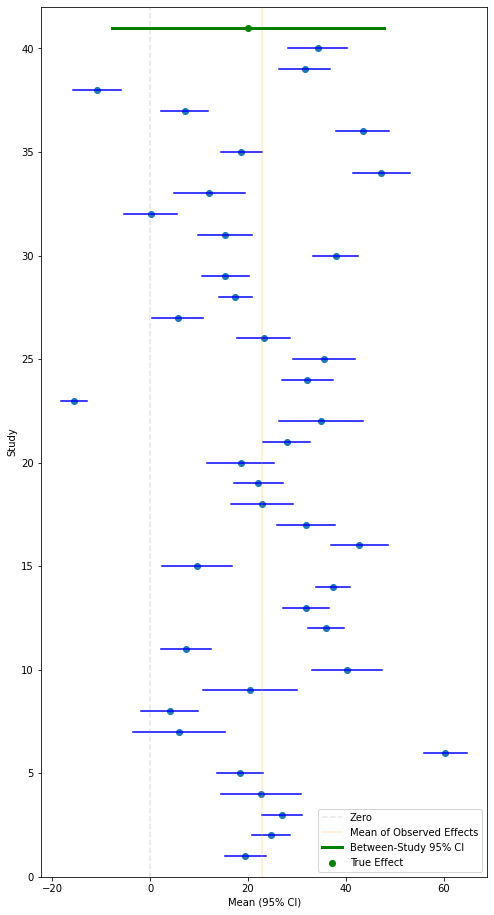

In [7]:
fig, ax = plt.subplots(figsize=(8, 16))
study_ticks = np.arange(n_studies)

# Get 95% CI for individual studies
lower_bounds, upper_bounds = var_to_ci(y, v, n)
ax.scatter(y, study_ticks+1)
for study in study_ticks:
    ax.plot((lower_bounds[study], upper_bounds[study]), (study+1, study+1), color='blue')
ax.axvline(0, color='gray', alpha=0.2, linestyle='--', label='Zero')
ax.axvline(np.mean(y), color='orange', alpha=0.2, label='Mean of Observed Effects')

# Get 95% CI for true effect
lower_bound, upper_bound = var_to_ci(true_effect, between_study_var, 1)
ax.scatter((true_effect,), (n_studies+1,), color='green', label='True Effect')
ax.plot((lower_bound, upper_bound), (n_studies+1, n_studies+1),
        color='green', linewidth=3, label='Between-Study 95% CI')
ax.set_ylim((0, n_studies+2))
ax.set_xlabel('Mean (95% CI)')
ax.set_ylabel('Study')
ax.legend()
fig.show()

## Create a Dataset object containing the data

In [8]:
dset = pymare.Dataset(y=y, X=None, v=v, n=n, add_intercept=True)

# Here is a dictionary to house results across models
results = {}

## Fit a model

When you have `z` or `p`:
- Stouffer
- Fisher

When you have `y` and `v` and don't want to estimate between-study variance:
- WeightedLeastSquares

When you have `y` and `v` and want to estimate between-study variance:
- DerSimonianLaird
- Hedges
- VarianceBasedLikelihoodEstimator

When you have `y` and `n` and want to estimate between-study variance:
- SampleSizeBasedLikelihoodEstimator

When you have `y` and `v` and want a hierarchical model:
- StanMetaRegression

### First, we have "combination models", which combine p and/or z values
The two combination models in PyMARE are Stouffer's and Fisher's Tests.

Notice that these models don't use `Dataset` objects.

In [9]:
stouff = pymare.estimators.Stouffers(input='z')
stouff.fit(y=z[:, None])
stouff_summary = stouff.summary()
print('z: {}'.format(stouff_summary.z))
print('p: {}'.format(stouff_summary.p))

z: [1.00546702]
p: [0.31467202]


In [10]:
fisher = pymare.estimators.Stouffers(input='z')
fisher.fit(y=z[:, None])
fisher_summary = fisher.summary()
print('z: {}'.format(fisher_summary.z))
print('p: {}'.format(fisher_summary.p))

z: [1.00546702]
p: [0.31467202]


### Now we have fixed effects model

This estimator does not attempt to estimate between-study variance. Instead, it takes `tau^2` as an argument.

In [11]:
wls = pymare.estimators.WeightedLeastSquares()
wls.fit(dset)
wls_summary = wls.summary()
results['Weighted Least Squares'] = wls_summary.to_df()
print(wls_summary.to_df())

        name   estimate        se   z-score       p-value  ci_0.025   ci_0.975
0  intercept  20.326462  2.967198  6.850389  7.364998e-12  14.51086  26.142063


### Methods that estimate between-study variance

The `DerSimonianLaird`, `Hedges`, and `VarianceBasedLikelihoodEstimator` estimators all estimate between-study variance from the data, and use `y` and `v`.

`DerSimonianLaird` and `Hedges` use relatively simple methods for estimating between-study variance, while `VarianceBasedLikelihoodEstimator` can use either maximum-likelihood (ML) or restricted maximum-likelihood (REML) to iteratively estimate it.

In [12]:
dsl = pymare.estimators.DerSimonianLaird()
dsl.fit(dset)
dsl_summary = dsl.summary()
results['DerSimonian-Laird'] = dsl_summary.to_df()
print(dsl_summary.to_df())

        name   estimate        se   z-score       p-value  ci_0.025   ci_0.975
0  intercept  20.326462  2.967198  6.850389  7.364998e-12  14.51086  26.142063


In [13]:
hedge = pymare.estimators.Hedges()
hedge.fit(dset)
hedge_summary = hedge.summary()
results['Hedges'] = hedge_summary.to_df()
print(hedge_summary.to_df())

        name   estimate        se     z-score  p-value   ci_0.025   ci_0.975
0  intercept  20.326462  0.158114  128.555832      0.0  20.016564  20.636359


In [14]:
vb_ml = pymare.estimators.VarianceBasedLikelihoodEstimator(method='ML')
vb_ml.fit(dset)
vb_ml_summary = vb_ml.summary()
results['Variance-Based with ML'] = vb_ml_summary.to_df()
print(vb_ml_summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.606514  3.077402  6.696075  2.140910e-11  14.574917   

    ci_0.975  
0  26.638111  


In [15]:
vb_reml = pymare.estimators.VarianceBasedLikelihoodEstimator(method='REML')
vb_reml.fit(dset)
vb_reml_summary = vb_reml.summary()
results['Variance-Based with REML'] = vb_reml_summary.to_df()
print(vb_reml_summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.660719  3.101268  6.662023  2.700840e-11  14.582345   

    ci_0.975  
0  26.739093  


The `SampleSizeBasedLikelihoodEstimator` estimates between-study variance using `y` and `n`, but assumes within-study variance is homogenous across studies.

In [16]:
sb_ml = pymare.estimators.SampleSizeBasedLikelihoodEstimator(method='ML')
sb_ml.fit(dset)
sb_ml_summary = sb_ml.summary()
results['Sample Size-Based with ML'] = sb_ml_summary.to_df()
print(sb_ml_summary.to_df())

        name  estimate        se   z-score  p-value   ci_0.025   ci_0.975
0  intercept  22.91788  2.450766  9.351311      0.0  18.114466  27.721294


In [17]:
sb_reml = pymare.estimators.SampleSizeBasedLikelihoodEstimator(method='REML')
sb_reml.fit(dset)
sb_reml_summary = sb_reml.summary()
results['Sample Size-Based with REML'] = sb_reml_summary.to_df()
print(sb_reml_summary.to_df())

        name   estimate        se   z-score  p-value   ci_0.025  ci_0.975
0  intercept  22.917806  2.481961  9.233751      0.0  18.053253  27.78236


### What about the Stan estimator?
We're going to skip this one here because of how computationally intensive it is.

## Let's check out our results!

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


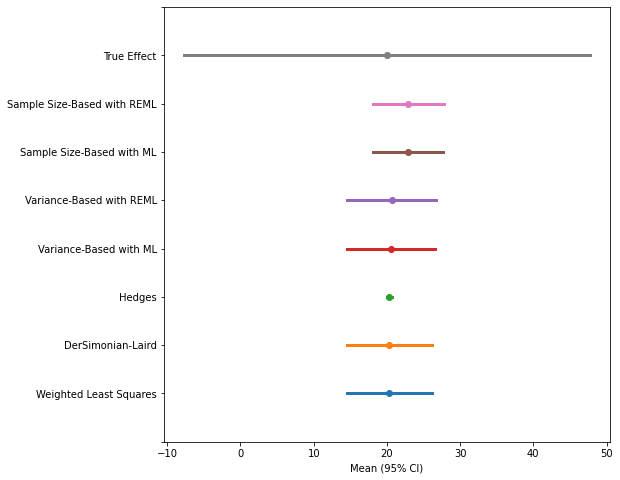

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, (estimator_name, summary_df) in enumerate(results.items()):
    ax.scatter((summary_df.loc[0, 'estimate'],), (i+1,), label=estimator_name)
    ax.plot((summary_df.loc[0, 'ci_0.025'],  summary_df.loc[0, 'ci_0.975']), 
            (i+1, i+1), 
            linewidth=3)

# Get 95% CI for true effect
lower_bound, upper_bound = var_to_ci(true_effect, between_study_var, 1)
ax.scatter((true_effect,), (i+2,), label='True Effect')
ax.plot((lower_bound, upper_bound), (i+2, i+2),
        linewidth=3, label='Between-Study 95% CI')
ax.set_ylim((0, i+3))
ax.set_yticklabels([None] + list(results.keys()) + ['True Effect'])

ax.set_xlabel('Mean (95% CI)')
fig.show()